In [52]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [53]:
data = pd.read_csv('Influenza_Surveillance_Weekly_-_Historical.csv')
print(data.head())


   MMWR_WEEK  WEEK_START    WEEK_END FLU_RISK_LEVEL INFLUENZA_SEASON  \
0     202401  12/31/2023  01/06/2024           HIGH        2023-2024   
1     202438  09/15/2024  09/21/2024            LOW        2023-2024   
2     202427  06/30/2024  07/06/2024            LOW        2023-2024   
3     202306  02/05/2023  02/11/2023     DECREASING        2022-2023   
4     202307  02/12/2023  02/18/2023     DECREASING        2022-2023   

   HOSP_FLU_ICU_WEEKLY  HOSP_FLU_ICU_CUMULATIVE  LAB_FLU_TESTED  \
0                   27                      155            6761   
1                    0                      302            2512   
2                    1                      300            1973   
3                    2                      191            4475   
4                    2                      193            4496   

   LAB_FLU_POSITIVE  LAB_FLU_PCT_POSITIVE  ...  LAB_TOT_POSITIVE_CUMULATIVE  \
0               785                  0.12  ...                         4918   
1     

In [54]:
data['WEEK_START'] = pd.to_datetime(data['WEEK_START'])
data['WEEK_END'] = pd.to_datetime(data['WEEK_END'])

sorted_data = data.sort_values('WEEK_START')

filter_date = pd.to_datetime('2021-10-01')
end_date = pd.to_datetime('2025-12-31')
sorted_filtered_data = sorted_data[sorted_data['WEEK_START'] >= filter_date] # Filter data from 2021 onwards
print(sorted_filtered_data.tail())


    MMWR_WEEK WEEK_START   WEEK_END FLU_RISK_LEVEL INFLUENZA_SEASON  \
13     202435 2024-08-25 2024-08-31            LOW        2023-2024   
14     202436 2024-09-01 2024-09-07            LOW        2023-2024   
15     202437 2024-09-08 2024-09-14            LOW        2023-2024   
1      202438 2024-09-15 2024-09-21            LOW        2023-2024   
10     202439 2024-09-22 2024-09-28            LOW        2023-2024   

    HOSP_FLU_ICU_WEEKLY  HOSP_FLU_ICU_CUMULATIVE  LAB_FLU_TESTED  \
13                    0                      300            2100   
14                    1                      301            2097   
15                    1                      302            2679   
1                     0                      302            2512   
10                    0                      302            2341   

    LAB_FLU_POSITIVE  LAB_FLU_PCT_POSITIVE  ...  LAB_TOT_POSITIVE_CUMULATIVE  \
13                 7                   0.0  ...                        11277   
14  

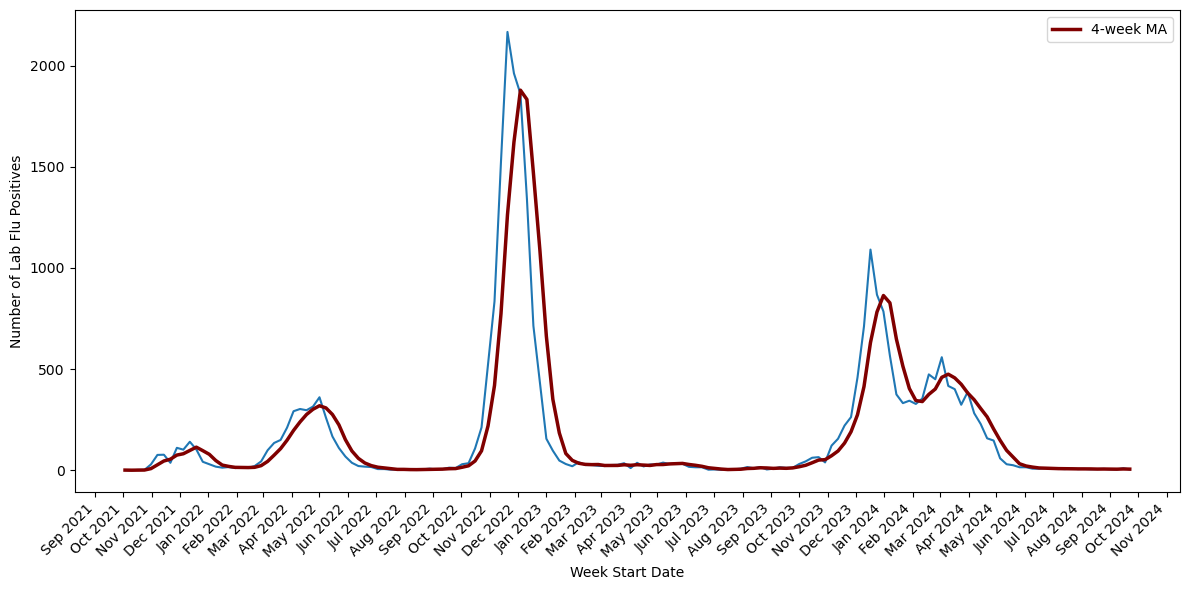

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(sorted_filtered_data['WEEK_START'], sorted_filtered_data['LAB_FLU_POSITIVE'])
plt.xlabel('Week Start Date')


plt.ylabel('Number of Lab Flu Positives')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
plt.xticks(rotation=45, ha='right', )
plt.tight_layout()

#Plot a moving average
ma_window = 4
weekly_positive = sorted_filtered_data.set_index('WEEK_START')['LAB_FLU_POSITIVE']

moving_avg = weekly_positive.rolling(window=ma_window, min_periods=1).mean()
ax.plot(moving_avg.index, moving_avg.values, color='maroon', linewidth=2.5, label=f'{ma_window}-week MA', zorder=3)
ax.legend()
plt.show()



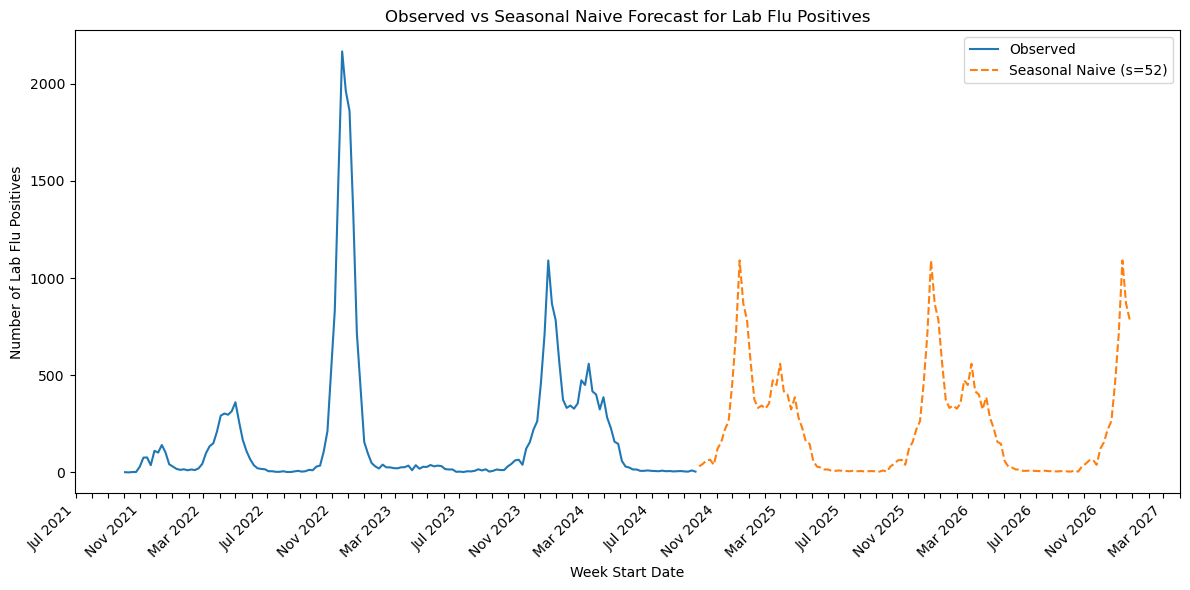

In [ ]:
# Seasonal Naive Forecasting
s = 52
y = weekly_positive

start_forecast = y.index[-1] + pd.Timedelta(days=7)
end_forecast = pd.to_datetime('2026-12-31')
future_idx = pd.date_range(start=start_forecast, end=end_forecast, freq='7D')

sn_values = []
shifted_dates = future_idx - pd.Timedelta(days=7 * s)

for sd in shifted_dates:

    if sd in y.index:
        sn_values.append(y.loc[sd])
    else:
        val = y.reindex([sd], method='nearest', tolerance=pd.Timedelta(days=3)).iloc[0]
        if pd.isna(val):
            last_s = y[-s:]
            pos = len(sn_values) % len(last_s)
            val = last_s.iloc[pos]
        sn_values.append(val)

sn_forecast = pd.Series(sn_values, index=future_idx, name='seasonal_naive_forecast')

# plot to compare observed and seasonal-naive forecast
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y.index, y.values, label='Observed', zorder=2)
ax.plot(sn_forecast.index, sn_forecast.values, color='tab:orange', linestyle='--', label='Seasonal Naive (s=52)', zorder=3)
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title('Observed vs Seasonal Naive Forecast for Lab Flu Positives')
labels = ax.get_xticklabels()
for i, lbl in enumerate(labels):
    lbl.set_visible(i % 4 == 0)
plt.setp(labels, rotation=45, ha='right')
plt.ylabel('Number of Lab Flu Positives')
plt.xlabel('Week Start Date')
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# series to model: weekly_positive
y = weekly_positive.copy()

# define seasonal period for weekly data with yearly seasonality (52 weeks)
s = 52
# SARIMA model order (p,d,q)(P,D,Q,s)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, s)

# fit model
model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
res = model.fit()

# build forecast index through end of 2026 
start_forecast = y.index[-1] + pd.Timedelta(days=7)
end_forecast = pd.to_datetime('2026-12-31')
future_idx = pd.date_range(start=start_forecast, end=end_forecast, freq='7D')

# produce forecasts
pred = res.get_forecast(steps=len(future_idx))
forecast = pd.Series(pred.predicted_mean.values, index=future_idx)

c:\Users\apcoc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\apcoc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\apcoc\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\apcoc\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


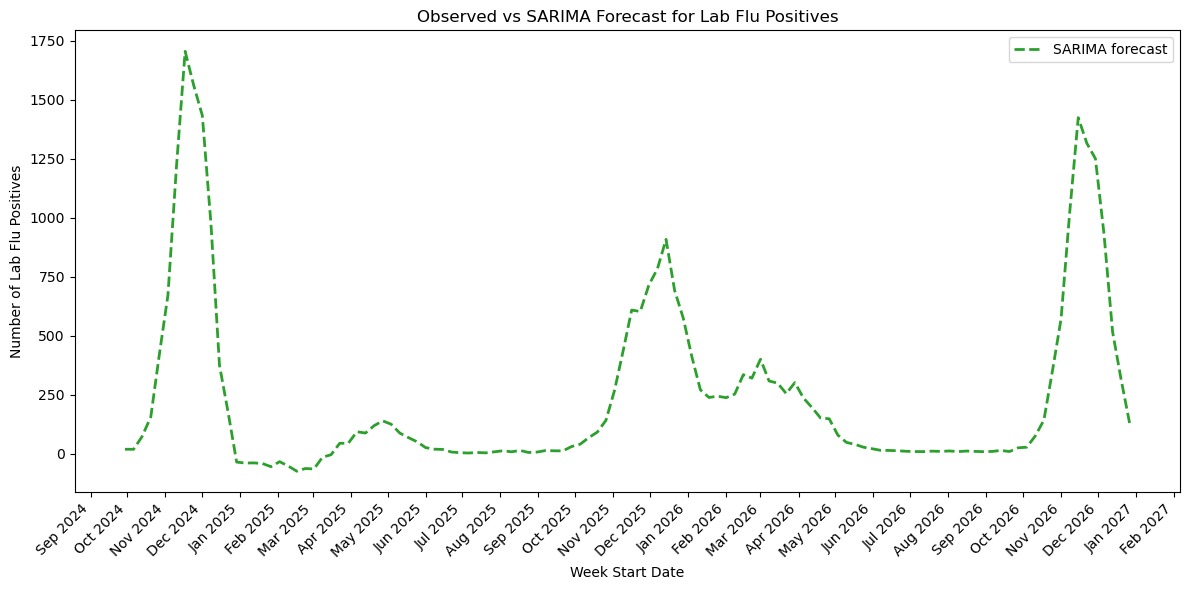

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(forecast.index, forecast.values, color='tab:green', linestyle='--', linewidth=2, label='SARIMA forecast')
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
ax.set_title('Observed vs SARIMA Forecast for Lab Flu Positives')
plt.xticks(rotation=45, ha='right', )
plt.ylabel('Number of Lab Flu Positives')
plt.xlabel('Week Start Date')
plt.tight_layout()
plt.show()

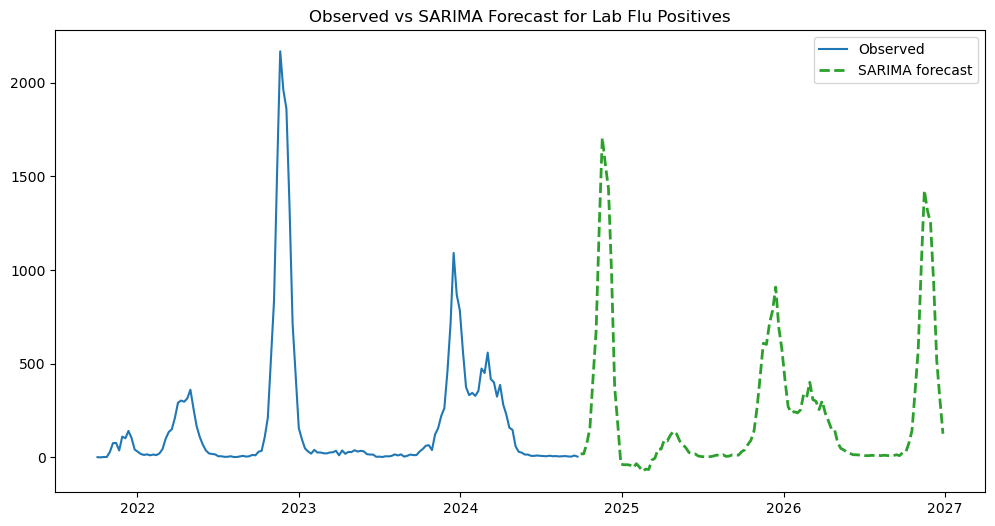

In [65]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Observed vs SARIMA Forecast for Lab Flu Positives')
ax.plot(sorted_filtered_data['WEEK_START'], sorted_filtered_data['LAB_FLU_POSITIVE'], label='Observed', zorder=2)
ax.plot(forecast.index, forecast.values, color='tab:green', linestyle='--', linewidth=2, label='SARIMA forecast', zorder=3)
ax.legend()


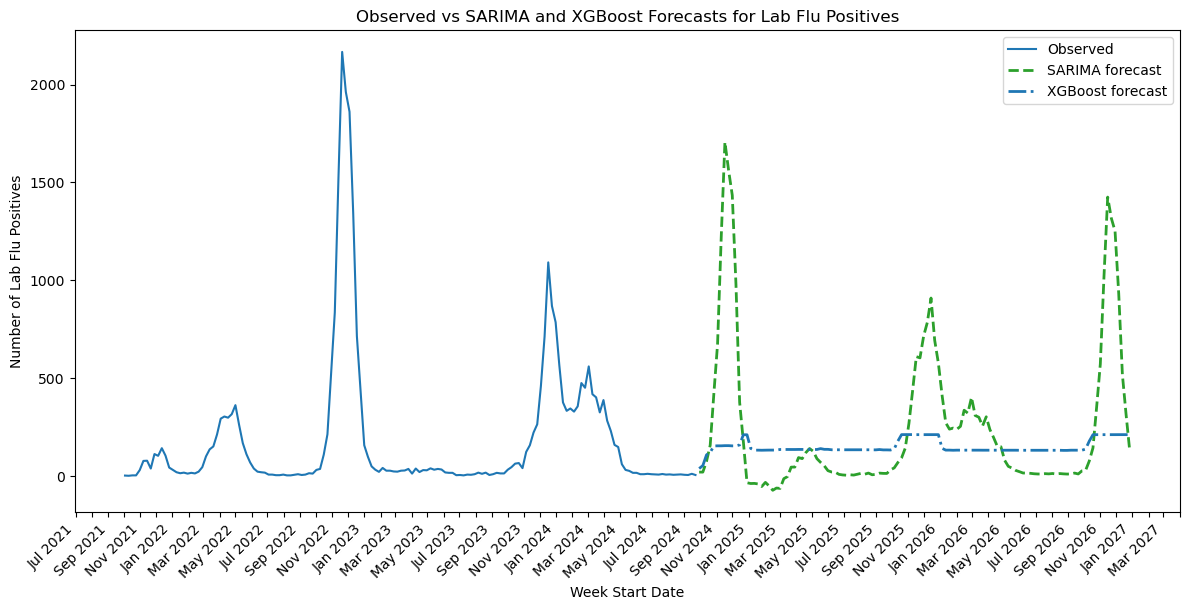

In [ ]:
from xgboost import XGBRegressor

# XGBoost forecast through 2026 (weekly)

# use the weekly series already present
series = weekly_positive.copy()  # index = WEEK_START, values = LAB_FLU_POSITIVE

# feature engineering function

df = series.to_frame(name='y').copy()
# lags (recent + seasonal)
lags = [1,2,3,4,52]
for l in lags:
    df[f'lag_{l}'] = df['y'].shift(l)
# rolling stats (use shifted window so we don't leak current y)
df['roll_4'] = df['y'].shift(1).rolling(4, min_periods=1).mean()
df['roll_8'] = df['y'].shift(1).rolling(8, min_periods=1).mean()
df['roll_52'] = df['y'].shift(1).rolling(52, min_periods=1).mean()
# date features
df['week'] = df.index.isocalendar().week.astype(int)
df['month'] = df.index.month
df['year'] = df.index.year
df = df.dropna()

df_feat = df.copy()

val_weeks = 26
train_df = df_feat.iloc[:-val_weeks]
val_df = df_feat.iloc[-val_weeks:]

X_train = train_df.drop(columns='y')
y_train = train_df['y']
X_val = val_df.drop(columns='y')
y_val = val_df['y']


xgb = XGBRegressor(objective='reg:squarederror', n_estimators=10000, learning_rate=0.05,booster='dart')
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# iterative multi-step forecast through end_forecast
horizon_idx = pd.date_range(start=start_forecast, end=end_forecast, freq='7D')
preds = []
extended = series.copy() 

lags = [1,2,3,4,52]
for tdate in horizon_idx:
    # build features for this timestamp from extended series
    feat = {}
    for l in lags:
        if len(extended) >= l:
            feat[f'lag_{l}'] = extended.iloc[-l]
        else:
            feat[f'lag_{l}'] = extended.iloc[0]  # fallback (shouldn't usually happen)

    feat['roll_4'] = extended.shift(1).rolling(4, min_periods=1).mean().iloc[-1]
    feat['roll_8'] = extended.shift(1).rolling(8, min_periods=1).mean().iloc[-1]
    feat['roll_52'] = extended.shift(1).rolling(52, min_periods=1).mean().iloc[-1]
    feat['week'] = int(tdate.isocalendar().week)
    feat['month'] = tdate.month
    feat['year'] = tdate.year

    X_row = pd.DataFrame([feat], index=[tdate])
    yhat = xgb.predict(X_row)[0]

    yhat = max(0.0, float(yhat))
    preds.append(yhat)
    extended.loc[tdate] = yhat

xgb_forecast = pd.Series(preds, index=horizon_idx, name='xgb_forecast')

fig_xgb, ax_xgb = plt.subplots(figsize=(12,6))
ax_xgb.plot(y.index, y.values, label='Observed', zorder=2)
ax_xgb.plot(forecast.index, forecast.values, color='tab:green', linestyle='--', linewidth=2, label='SARIMA forecast', zorder=3)
ax_xgb.plot(xgb_forecast.index, xgb_forecast.values, color='tab:blue', linestyle='-.', linewidth=2, label='XGBoost forecast', zorder=4)
ax_xgb.set_xlabel('Week Start Date')
ax_xgb.set_ylabel('Number of Lab Flu Positives')
ax_xgb.xaxis.set_major_locator(mdates.MonthLocator())
ax_xgb.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
labels = ax_xgb.get_xticklabels()
for i, lbl in enumerate(labels):
    lbl.set_visible(i % 2 == 0)
plt.xticks(rotation=45, ha='right')
ax_xgb.legend()
plt.tight_layout()
plt.title('Observed vs SARIMA and XGBoost Forecasts for Lab Flu Positives')
plt.show()